# Notebook report:
This notebook analyzes **latent-thought steps in CODI** to find **“anchor” latent steps** (steps that later latent steps consistently attend to) and tests whether those anchors are **causally important** via ablations.

## Methodology category
- **Attention Analysis** (primary): captures per-layer/per-head attention during latent steps and studies inter-latent attention flow.
- **Latent Step Manipulation** (secondary): zero-ablation of a chosen latent step to test causal impact.

## What it does

### 1) Phase 1: Trace collection during latent reasoning
For each question (typically GSM8K / GSM8k-Aug):
- Runs CODI with `inf_latent_iterations` (often 6) latent steps.
- Captures **attention weights** for each latent step across layers/heads.
- Logs per-step **decoded top-k intermediate tokens** (“decoded latent steps”).
- Generates a final answer and computes accuracy.

**Outputs**
- `per_question_attention_weights.pt`  
  Tensor of attention data shaped like:  
  `[num_questions, num_latent_steps, num_layers, num_heads, max_seq_len]`
- `phase1_data_collection.json`  
  Per-question metadata: question text, model output, extracted answer, and per-latent-step decoded top-k tokens (and sometimes latent tensors serialized).

### 2) Visualization: inter-latent attention heatmaps
Loads `per_question_attention_weights.pt` + `phase1_data_collection.json` and builds:
- **Per-question heatmaps** showing how later latent steps attend to earlier latent steps (`z_i → z_j`).
- An **average heatmap** by averaging attention over many questions.

### 3) Anchor identification
For each question:
- Computes an “anchor score” for each latent step `z_j` by summing attention from later steps (`z_i`, `i>j`) back to `z_j` (aligned using prompt length).
- Applies softmax and a confidence threshold:
  - high-confidence anchor = argmax if max prob > threshold
  - otherwise mark as ambiguous (`-1`)

### 4) Causal test: latent-step ablation sweep
For high-confidence examples:
- **Baseline:** normal inference
- **Anchor ablation:** set `latent_embd = 0` at predicted anchor step
- **Control ablation:** set `latent_embd = 0` at a random non-anchor step
Reports accuracy differences and sweeps thresholds to see where the effect is strongest.

## Key sanity checks
- Confirm files exist after Phase 1: `per_question_attention_weights.pt`, `phase1_data_collection.json`
- Verify tensor shapes match expectations (latent steps × layers × heads × seq len).
- Ensure `prompt_len + j` indexing aligns latent positions correctly; misalignment breaks anchor scores.



In [6]:
import logging
import math
import re
import os
from dataclasses import dataclass, field
from typing import Dict, Optional, Sequence

import torch
import transformers
from torch.nn import functional as F
import json

from peft import PeftModel, LoraConfig, TaskType, get_peft_model
from datasets import load_dataset
from accelerate.utils import set_seed
from safetensors.torch import load_file

import numpy as np

from src.model import (
    CODI,
    ModelArguments,
    DataArguments,
    TrainingArguments,
)

do_print = True
probe_topk = 5
probe_idx = None
test_attention = True

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

# Global list to store attention weights captured by hooks for a single step
captured_attentions = []

def get_attention_hook(module, input, output):
    """Captures the full attention weight tensor from a model's attention layer."""
    if isinstance(output, tuple) and len(output) > 1 and output[1] is not None:
        attn = None
        if len(output) >= 3 and torch.is_tensor(output[2]):
            attn = output[2]
        elif torch.is_tensor(output[-1]):
            attn = output[-1]

        if attn is not None:
            captured_attentions.append(attn.detach().cpu())

def evaluation(model_args, data_args, training_args):
    if model_args.lora_init:
        task_type = TaskType.CAUSAL_LM
        if any(name in model_args.model_name_or_path.lower() for name in ["llama", "mistral", "falcon", "qwen"]):
            target_modules = ["q_proj", "k_proj", "v_proj", "o_proj", "up_proj", "down_proj", "gate_proj"]
        elif any(name in model_args.model_name_or_path.lower() for name in ["phi"]):
            target_modules = ["q_proj", "k_proj", "v_proj", "dense", "fc1", "fc2"]
        elif any(name in model_args.model_name_or_path.lower() for name in ["gpt2"]):
            target_modules = ["c_attn", "c_proj", 'c_fc']
        else:
            raise ValueError(f"Only support LLAMA, Mistral, Falcon, Phi-2, but got {model_args.model_name_or_path}.")
        lora_config = LoraConfig(
            task_type=task_type,
            inference_mode=False,
            r=model_args.lora_r,
            lora_alpha=model_args.lora_alpha,
            lora_dropout=0.1,
            target_modules=target_modules,
            init_lora_weights=True,
        )
    else:
        raise NotImplementedError

    model = CODI(model_args, training_args, lora_config)

    try:
        state_dict = load_file(os.path.join(model_args.ckpt_dir, "model.safetensors"))
    except Exception:
        state_dict = torch.load(os.path.join(model_args.ckpt_dir, "pytorch_model.bin"))
    model.load_state_dict(state_dict, strict=False)
    model.codi.tie_weights()

    for layer in model.codi.transformer.h:
        layer.attn.register_forward_hook(get_attention_hook)

    tokenizer = transformers.AutoTokenizer.from_pretrained(
        model_args.model_name_or_path,
        token=model_args.token,
        model_max_length=training_args.model_max_length,
        padding_side="left",
        use_fast=False,
    )

    if tokenizer.pad_token_id is None:
        tokenizer.add_special_tokens({'pad_token': '[PAD]'})
        tokenizer.pad_token_id = model.pad_token_id
        if tokenizer.pad_token_id is None:
            tokenizer.pad_token_id = tokenizer.convert_tokens_to_ids('[PAD]')

    model = model.to(device)
    model.to(torch.bfloat16)

    logging.warning("Downloading Data")
    dataset = load_dataset(data_args.data_name)
    test_set = dataset['test'].select(range(1000))

    logging.warning("Formatting inputs...")
    question = [f"{ex['question'].strip().replace('  ', ' ')}" for ex in test_set]
    answer = [float(ex['answer'].replace(",", "")) for ex in test_set]
    procedures = [ex["cot"] for ex in test_set]

    logging.warning("Tokenizing inputs...")
    eval_step = math.ceil(len(question) / data_args.batch_size)
    logging.warning(f"Total example: {len(question)} | eval batch size: {data_args.batch_size} | eval steps: {eval_step}")

    question_data = []
    for i in range(eval_step):
        start_idx = i * data_args.batch_size
        end_idx = (i + 1) * data_args.batch_size
        batch_questions = question[start_idx:end_idx]
        batch = tokenizer(batch_questions, return_tensors="pt", padding="longest")

        if training_args.remove_eos:
            bot_tensor = torch.tensor([model.bot_id], dtype=torch.long).expand(batch["input_ids"].size(0), 1)
        else:
            bot_tensor = torch.tensor([tokenizer.eos_token_id, model.bot_id], dtype=torch.long).expand(batch["input_ids"].size(0), 2)

        batch["input_ids"] = torch.cat((batch["input_ids"], bot_tensor), dim=1)
        batch["attention_mask"] = torch.cat((batch["attention_mask"], torch.ones_like(bot_tensor)), dim=1)
        question_data.append(batch.to(device))

    model.eval()
    gen_kwargs = {"max_new_tokens": 256, "temperature": 0.1, "top_k": 40, "top_p": 0.95, "do_sample": True}

    ans_pred_list = []
    len_cot = []
    phase1_data_collection = []

    # ✅ Initialize a list to store attention tensors for each question
    all_question_attentions = []
    num_layers = model.codi.config.num_hidden_layers
    num_heads = model.codi.config.num_attention_heads
    max_seq_len = training_args.model_max_length
    num_latent_steps = training_args.inf_latent_iterations

    for step, batch in enumerate(question_data):
        batch_size = batch["input_ids"].size(0)

        # ✅ Create a temporary holder for the current batch's attention data
        batch_attention_holder = torch.zeros(
            batch_size, num_latent_steps, num_layers, num_heads, max_seq_len,
            dtype=torch.bfloat16, device='cpu'
        )

        batch_latent_data = [[] for _ in range(batch_size)]

        with torch.no_grad():
            outputs = model.codi(input_ids=batch["input_ids"], use_cache=True, output_hidden_states=True, past_key_values=None, attention_mask=batch["attention_mask"], output_attentions=True)
            past_key_values = outputs.past_key_values
            latent_embd = outputs.hidden_states[-1][:, -1, :].unsqueeze(1)

            if training_args.use_prj:
                latent_embd = model.prj(latent_embd)

            for i in range(training_args.inf_latent_iterations):
                global captured_attentions
                captured_attentions.clear()

                outputs = model.codi(inputs_embeds=latent_embd, use_cache=True, output_hidden_states=True, past_key_values=past_key_values, output_attentions=True)

                # ✅ Process attention weights without averaging them across the batch
                for layer_idx, layer_attention_weights in enumerate(captured_attentions):
                    squeezed_weights = layer_attention_weights.squeeze(2)
                    current_seq_len = squeezed_weights.shape[-1]

                    # Place the weights for the entire batch into the holder
                    batch_attention_holder[:, i, layer_idx, :, :current_seq_len] = squeezed_weights.to(torch.bfloat16)

                past_key_values = outputs.past_key_values
                current_latent_embd = outputs.hidden_states[-1][:, -1, :].unsqueeze(1)
                probs = torch.nn.functional.softmax(model.codi.lm_head(current_latent_embd), dim=-1)
                _, top5_indices = torch.topk(probs, k=probe_topk, dim=2)

                for b_idx in range(batch_size):
                    decoded_top5 = [tokenizer.decode(x) for x in top5_indices[b_idx, 0]]
                    batch_latent_data[b_idx].append({
                        "latent_token_index": i,
                        "latent_token_tensor": current_latent_embd[b_idx].clone().detach().cpu(),
                        "decoded_intermediate_output": decoded_top5
                    })

                latent_embd = current_latent_embd
                if training_args.use_prj:
                    latent_embd = model.prj(latent_embd)

            # ✅ After iterating through latent steps, add this batch's attention data to the main list
            # unbind splits the batch dimension, creating a list of tensors for each example
            all_question_attentions.extend(list(torch.unbind(batch_attention_holder, dim=0)))

            # --- Final Answer Generation ---
            if training_args.remove_eos:
                eot_emb = model.get_embd(model.codi, model.model_name)(torch.tensor([model.eot_id], dtype=torch.long, device='cuda')).unsqueeze(0).to(device)
            else:
                eot_emb = model.get_embd(model.codi, model.model_name)(torch.tensor([model.eot_id, tokenizer.eos_token_id], dtype=torch.long, device='cuda')).unsqueeze(0).to(device)

            output = eot_emb.expand(batch_size, -1, -1)

            finished = torch.zeros(batch_size, dtype=torch.bool, device="cuda")
            pred_tokens = [[] for _ in range(batch_size)]

            for _ in range(gen_kwargs["max_new_tokens"]):
                out = model.codi(inputs_embeds=output, use_cache=True, past_key_values=past_key_values, output_attentions=False)
                past_key_values = out.past_key_values
                logits = out.logits[:, -1, :model.codi.config.vocab_size-1]

                if training_args.greedy:
                    next_token_ids = torch.argmax(logits, dim=-1)
                else:
                    probs = F.softmax(logits / gen_kwargs["temperature"], dim=-1)
                    next_token_ids = torch.multinomial(probs, num_samples=1).squeeze(-1)

                for b in range(batch_size):
                    if not finished[b]:
                        token_id = next_token_ids[b].item()
                        pred_tokens[b].append(token_id)
                        if token_id == tokenizer.eos_token_id:
                            finished[b] = True

                if finished.all():
                    break

                output = model.get_embd(model.codi, model.model_name)(next_token_ids).unsqueeze(1)

            for mini_step, pred_token in enumerate(pred_tokens):
                len_cot.append(len(pred_token))
                decoded_pred = tokenizer.decode(pred_token, skip_special_tokens=True)

                current_question_idx = step * data_args.batch_size + mini_step
                pred_answer = extract_answer_number(decoded_pred)
                ans_pred_list.append(pred_answer)

                phase1_data_collection.append({
                    "question_id": current_question_idx,
                    "question_text": question[current_question_idx],
                    "ground_truth_cot": procedures[current_question_idx],
                    "ground_truth_answer": answer[current_question_idx],
                    "model_prediction_text": decoded_pred,
                    "model_prediction_answer": pred_answer,
                    "latent_data": batch_latent_data[mini_step]
                })

    # ✅ Finalize and save the collected per-question attention data
    # Stack the list of tensors into a single large tensor
    # Final Shape: [num_questions, num_latent_steps, num_layers, num_heads, max_seq_len]
    final_attention_tensor = torch.stack(all_question_attentions, dim=0)
    save_path = "per_question_attention_weights.pt"
    torch.save(final_attention_tensor, save_path)

    print("✅ Per-question analysis complete.")
    print(f"   Attention data saved to '{save_path}'")
    print(f"   Tensor shape: {final_attention_tensor.shape}")

    accuracy = compute_accuracy(answer, ans_pred_list)

    # Convert tensors in the main data collection to lists for JSON serialization
    def convert_tensors_to_lists(data):
        if isinstance(data, list):
            return [convert_tensors_to_lists(item) for item in data]
        elif isinstance(data, dict):
            return {key: convert_tensors_to_lists(value) for key, value in data.items()}
        elif isinstance(data, torch.Tensor):
            return data.detach().cpu().tolist()
        else:
            return data

    with open("phase1_data_collection.json", "w") as f:
        serializable_data = convert_tensors_to_lists(phase1_data_collection)
        json.dump(serializable_data, f, indent=2)

    print(f"adapter: {model_args.adapter_name_or_path} | GSM8K test accuracy: {100*accuracy:.2f}% | ")
    print(f"average length of COT: {sum(len_cot)/len(len_cot)}")

    return 100*accuracy

def extract_answer_number(sentence: str) -> float:
    sentence = sentence.replace(',', '')
    pred = [s for s in re.findall(r'-?\d+\.?\d*', sentence)]
    if not pred:
        return float('inf')
    return float(pred[-1])

def compute_accuracy(gold: list, pred: list):
    acc = sum(p == g for p, g in zip(pred, gold))
    return acc / len(gold)

if __name__ == "__main__":
    parser = transformers.HfArgumentParser((ModelArguments, DataArguments, TrainingArguments))
    args = [
        "--data_name", "zen-E/GSM8k-Aug",
        "--output_dir", "outputs/probe_latent_results",
        "--model_name_or_path", "./gpt2",
        "--seed", "11",
        "--model_max_length", "512",
        "--bf16",
        "--lora_r", "128",
        "--lora_alpha", "32",
        "--lora_init",
        "--batch_size", "32",
        "--greedy", "True",
        "--num_latent", "6",
        "--use_prj", "True",
        "--prj_dim", "768",
        "--prj_no_ln", "False",
        "--prj_dropout", "0.0",
        "--inf_latent_iterations", "6",
        "--inf_num_iterations", "1",
        "--remove_eos", "True",
        "--use_lora", "True",
        "--ckpt_dir", "CODI-gpt2"
    ]
    model_args, data_args, training_args = parser.parse_args_into_dataclasses(args)

    accu_list = []
    training_args.inf_num_iterations = 1
    for i in range(training_args.inf_num_iterations):
        accu = evaluation(model_args, data_args, training_args)
        accu_list.append(accu)
    print(f"Average accuracy over {training_args.inf_num_iterations} sampling: {sum(accu_list)/len(accu_list)}")

cuda


/lambda/nfs/SSSM/latent_reasoning/Scratchpad-Thinking/.venv-cu/lib/python3.11/site-packages/peft/tuners/lora/layer.py:2285: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
/tmp/ipykernel_6914/2584017655.py:78: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=

trainable params: 20057088 || all params: 144499200 || trainable%: 13.880414562848792


✅ Per-question analysis complete.
   Attention data saved to 'per_question_attention_weights.pt'
   Tensor shape: torch.Size([1000, 6, 12, 12, 512])
adapter: None | GSM8K test accuracy: 42.70% | 
average length of COT: 6.219
Average accuracy over 1 sampling: 42.699999999999996


Loading data, tokenizer, and analysis files...


/tmp/ipykernel_6914/3801624131.py:22: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  all_attention_data = torch.load(ATTENTION_FILE_PATH)


Data loaded successfully.

Generating 5 separate plots for individual examples with context...
  - Processing and plotting for example 5...
    saved: latentThoughtAnchorsOutput/number_focus_example_5.png


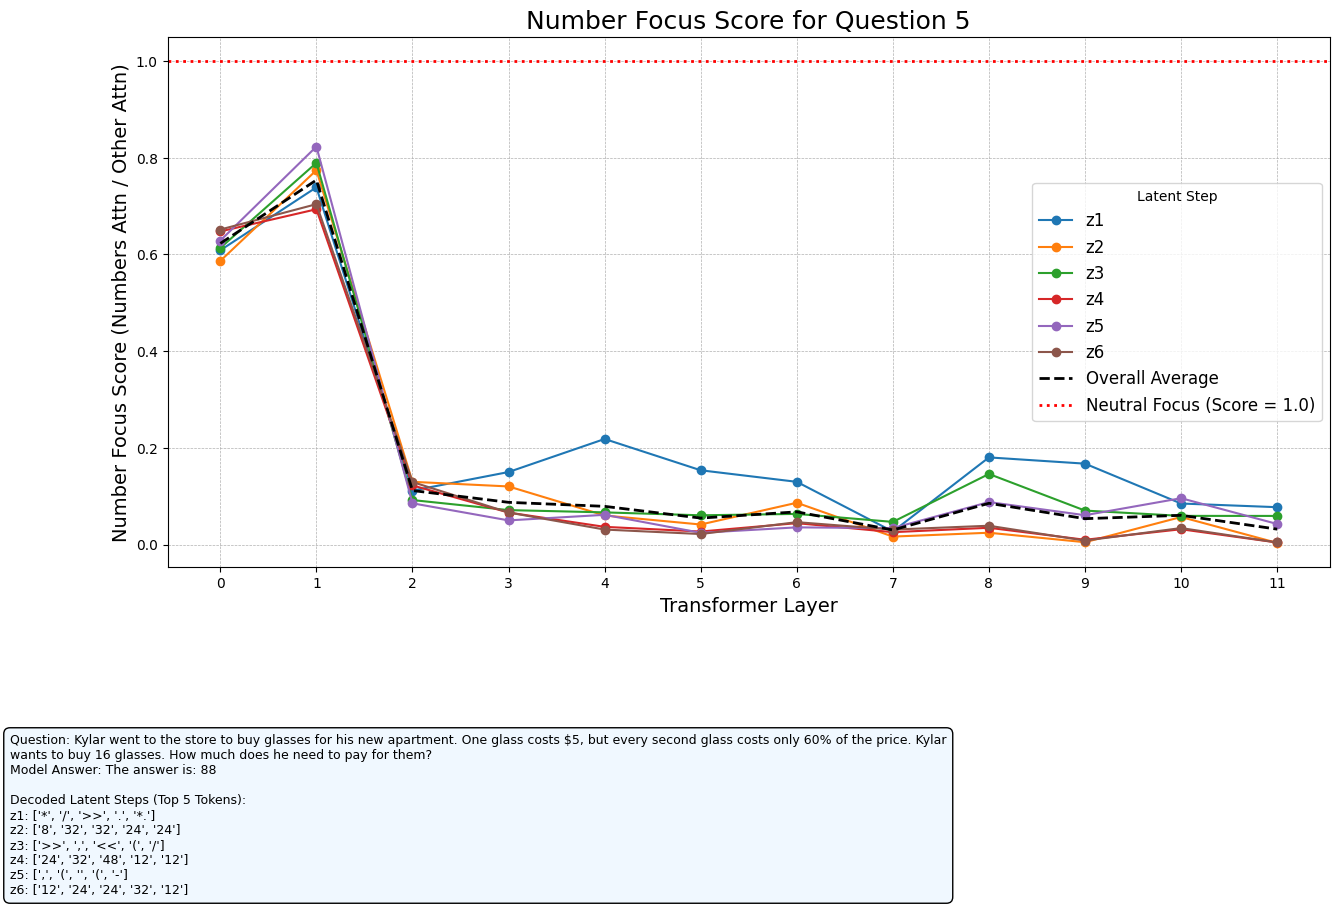

  - Processing and plotting for example 15...
    saved: latentThoughtAnchorsOutput/number_focus_example_15.png


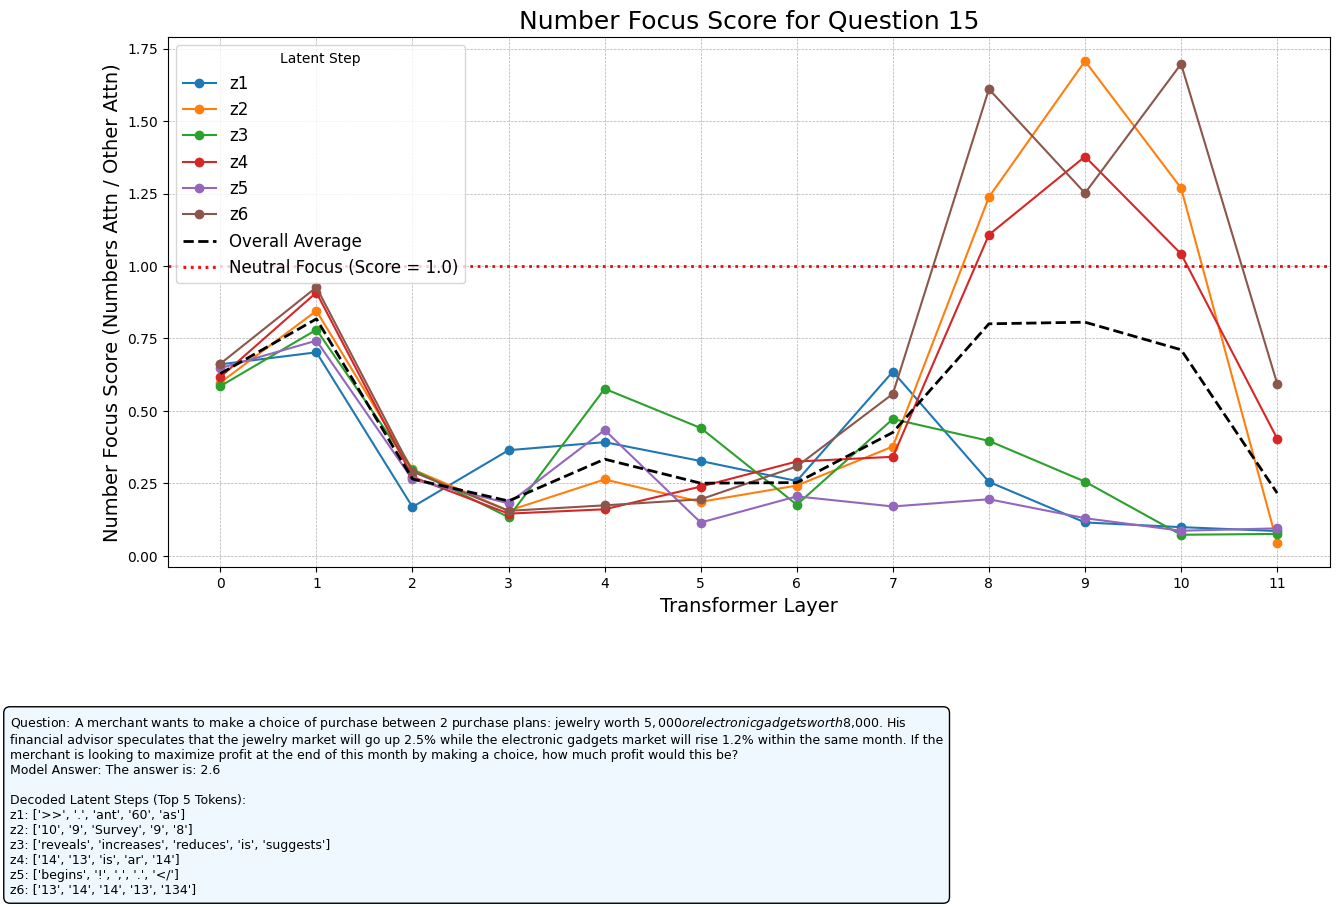

  - Processing and plotting for example 25...
    saved: latentThoughtAnchorsOutput/number_focus_example_25.png


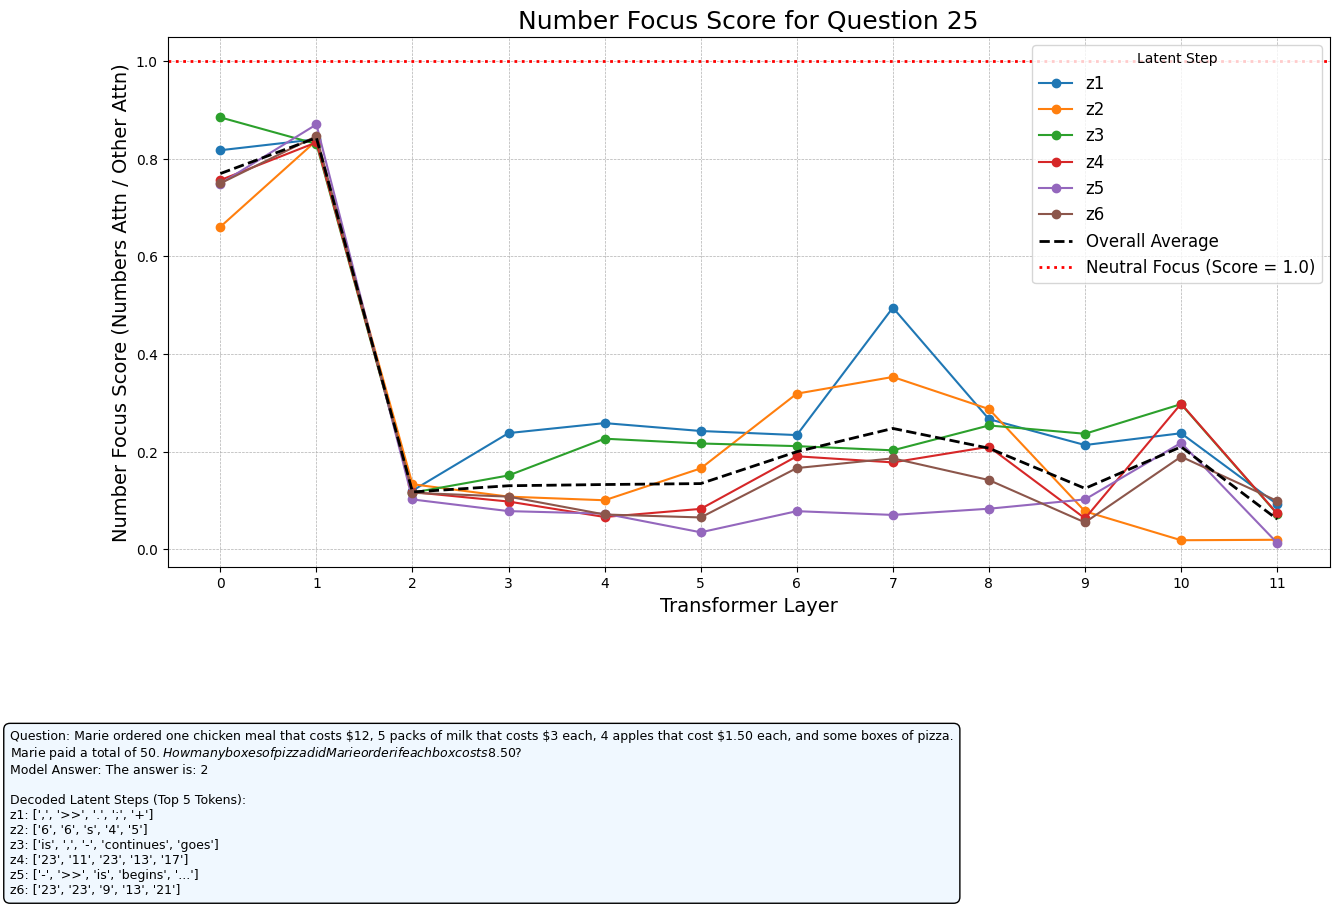

  - Processing and plotting for example 35...
    saved: latentThoughtAnchorsOutput/number_focus_example_35.png


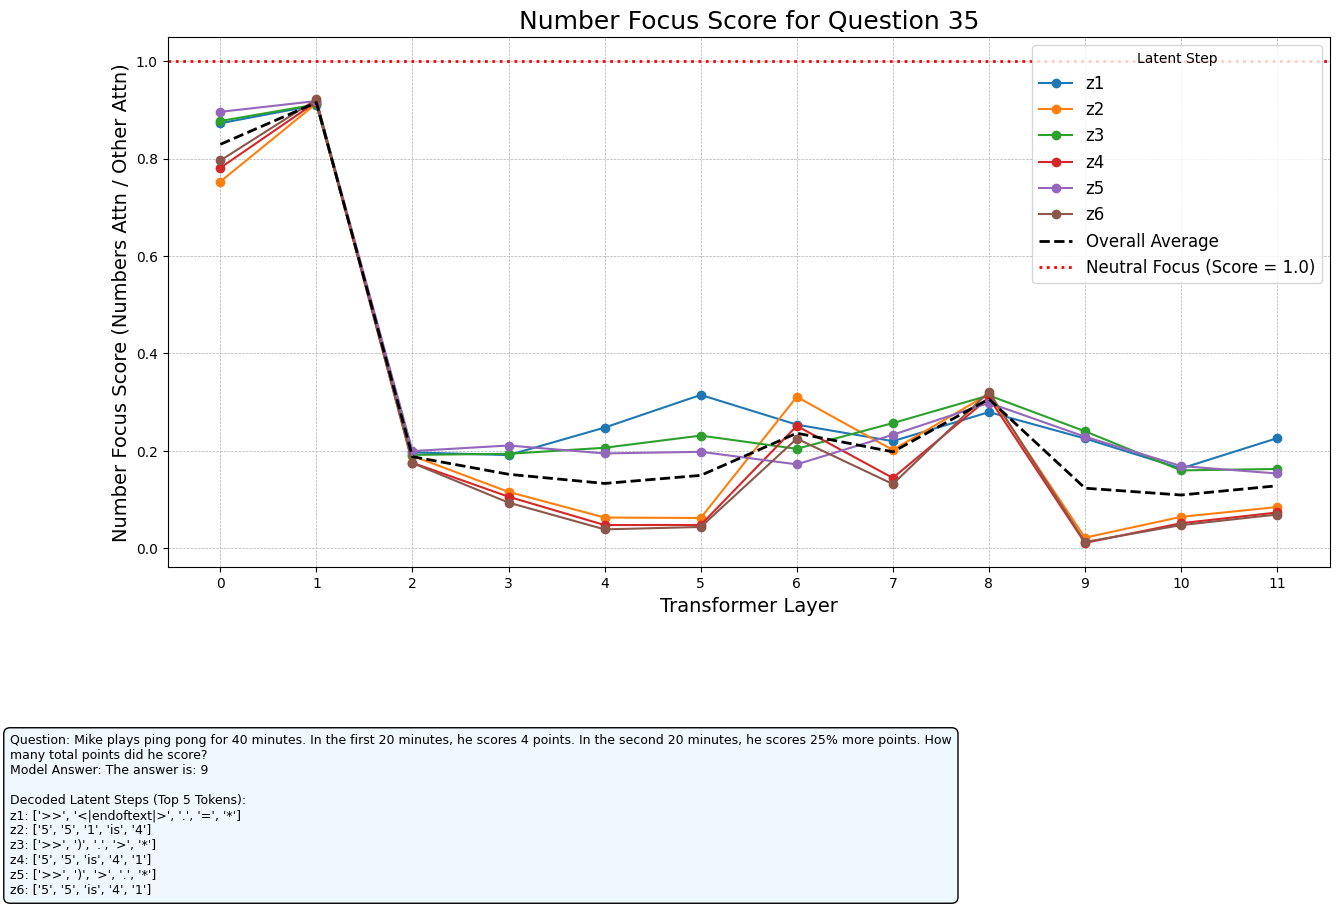

  - Processing and plotting for example 45...
    saved: latentThoughtAnchorsOutput/number_focus_example_45.png


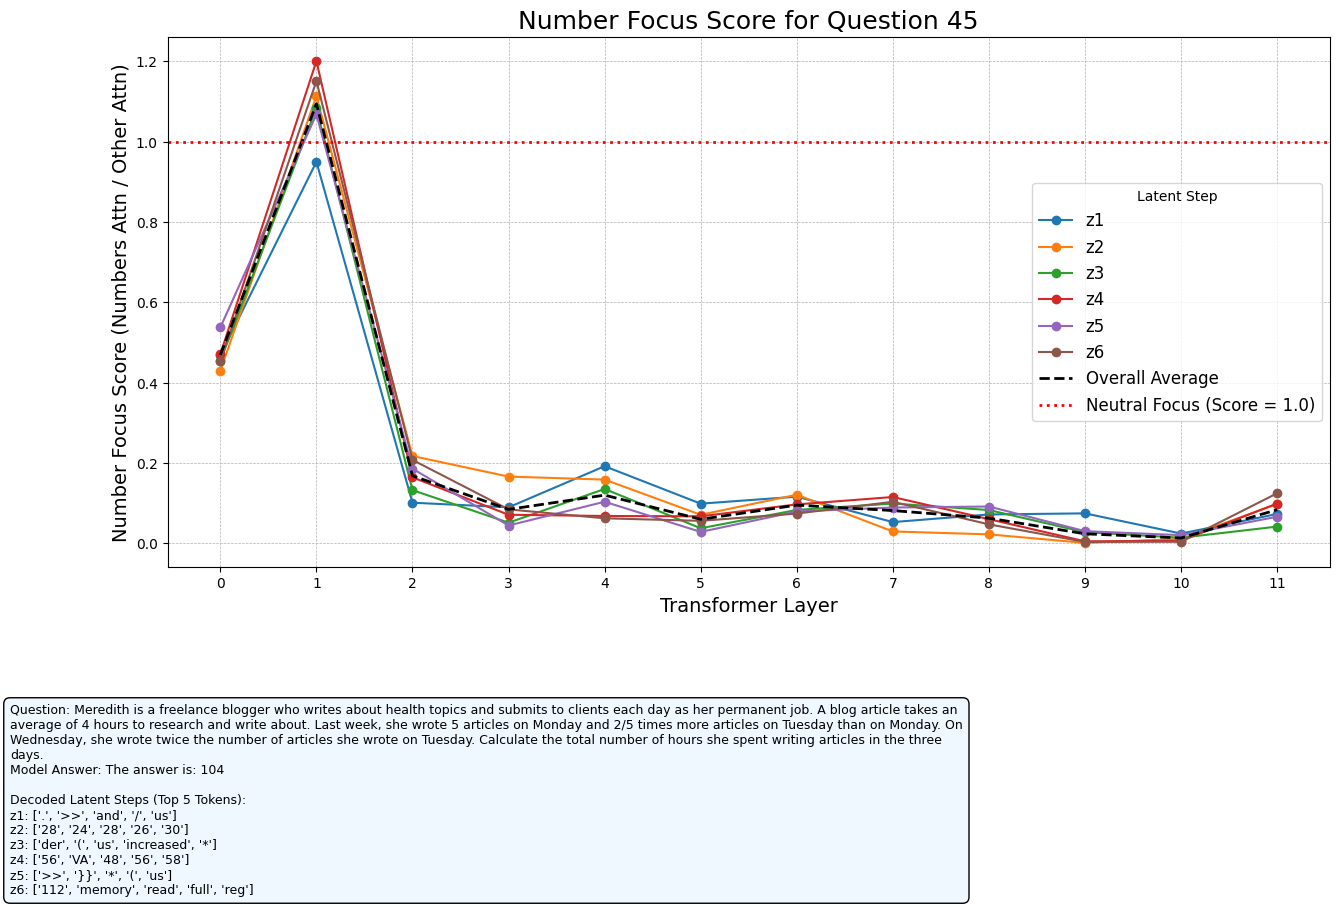


Generating plot for the average of all examples...
  - Calculating average focus scores...
saved: latentThoughtAnchorsOutput/number_focus_average_100.png


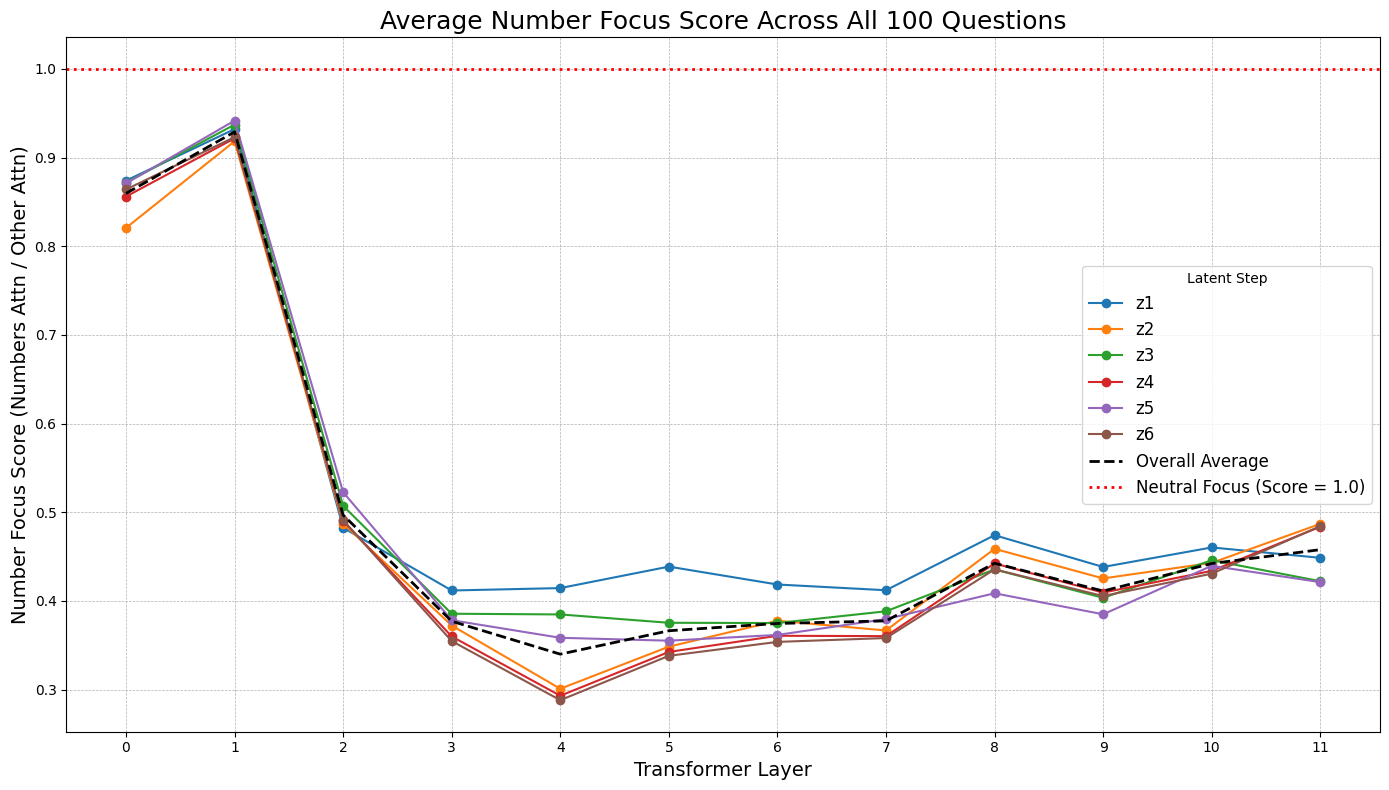


Analysis complete.


In [8]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from datasets import load_dataset
import transformers
import json
import textwrap

# --- Configuration ---
ATTENTION_FILE_PATH = "per_question_attention_weights.pt"
PHASE1_DATA_PATH = "phase1_data_collection.json"
EXAMPLE_INDICES_TO_PLOT = [5, 15, 25, 35, 45]

OUTPUT_DIR = "latentThoughtAnchorsOutput"
os.makedirs(OUTPUT_DIR, exist_ok=True)

# --- Load Data and Tools ---
print("Loading data, tokenizer, and analysis files...")
try:
    # Load the tensor containing attention data for all questions
    # Expected shape: [num_questions, num_latent_steps, num_layers, num_heads, max_seq_len]
    all_attention_data = torch.load(ATTENTION_FILE_PATH)
    with open(PHASE1_DATA_PATH, 'r') as f:
        phase1_data = json.load(f)
except FileNotFoundError as e:
    print(f"Error: A required file was not found: {e.filename}")
    print("Please make sure you have run the evaluation script to generate both 'per_question_attention_weights.pt' and 'phase1_data_collection.json'.")
    exit()

tokenizer = transformers.AutoTokenizer.from_pretrained("gpt2")
dataset = load_dataset("zen-E/GSM8k-Aug")
test_set = dataset['test'].select(range(100))
print("Data loaded successfully.")

# --- Core Calculation Function ---
def calculate_number_focus(attention_tensor, dataset, tokenizer):
    """
    Calculates the number focus score for a given attention tensor.

    The attention tensor can be for a single example or an average across many.

    Args:
        attention_tensor (torch.Tensor): A tensor of attention weights with shape
                                         [num_latent_steps, num_layers, num_heads, max_seq_len].
        dataset: The dataset containing the text examples.
        tokenizer: The tokenizer used to process the text.

    Returns:
        np.ndarray: A 2D numpy array of shape [num_latent_steps, num_layers] containing
                    the calculated focus scores.
    """
    num_latent_steps = attention_tensor.shape[0]
    num_layers = attention_tensor.shape[1]

    # Create a data structure to hold our scores
    number_focus_scores = np.zeros((num_latent_steps, num_layers))

    for latent_step_index in range(num_latent_steps):
        for layer_index in range(num_layers):

            # Get attention for this specific latent_step and layer, averaged over heads
            # Shape: [max_seq_len]
            attention_for_layer = attention_tensor[latent_step_index, layer_index].mean(dim=0)

            # Collect attention scores for number tokens vs. other tokens
            number_scores = []
            other_scores = []

            for example in dataset:
                question_text = example['question'].strip().replace('  ', ' ')
                token_ids = tokenizer(question_text, return_tensors="pt")["input_ids"][0]

                for i, token_id in enumerate(token_ids):
                    # Ensure we don't go out of bounds for the attention tensor
                    if i < len(attention_for_layer):
                        token = tokenizer.decode(token_id)
                        # Simple check if the token is a number
                        if token.strip().replace('.','').isdigit():
                            number_scores.append(attention_for_layer[i].item())
                        else:
                            other_scores.append(attention_for_layer[i].item())

            # Calculate the means, avoiding division by zero if a category is empty
            mean_num = np.mean(number_scores) if number_scores else 0
            mean_other = np.mean(other_scores) if other_scores else 1

            # Calculate and store the focus score ratio
            if mean_other > 0:
                number_focus_scores[latent_step_index, layer_index] = mean_num / mean_other
            else:
                number_focus_scores[latent_step_index, layer_index] = 0

    return number_focus_scores

# --- Plot 1: Five Separate Plots for Individual Examples ---
print("\nGenerating 5 separate plots for individual examples with context...")
num_layers = all_attention_data.shape[2]
num_latent_steps_individual = all_attention_data.shape[1]

for example_idx in EXAMPLE_INDICES_TO_PLOT:
    if example_idx < len(all_attention_data) and example_idx < len(phase1_data):
        print(f"  - Processing and plotting for example {example_idx}...")

        # Create a new figure and axes for each individual question plot
        fig_ind, ax_ind = plt.subplots(figsize=(15, 10))

        # Get the attention data for one specific question
        attention_for_example = all_attention_data[example_idx]

        # Calculate the focus scores just for this example
        focus_scores = calculate_number_focus(attention_for_example, [test_set[example_idx]], tokenizer)

        # Plot the focus score for each latent step as a separate line
        for i in range(num_latent_steps_individual):
            ax_ind.plot(np.arange(num_layers), focus_scores[i, :], marker='o', linestyle='-', label=f'z{i+1}')

        # Add a line for the average across all steps for this specific example
        average_across_steps = focus_scores.mean(axis=0)
        ax_ind.plot(np.arange(num_layers), average_across_steps, marker='', linestyle='--', color='black', linewidth=2, label='Overall Average')

        ax_ind.set_title(f'Number Focus Score for Question {example_idx}', fontsize=18)
        ax_ind.set_xlabel('Transformer Layer', fontsize=14)
        ax_ind.set_ylabel('Number Focus Score (Numbers Attn / Other Attn)', fontsize=14)
        ax_ind.set_xticks(np.arange(num_layers))
        ax_ind.axhline(y=1.0, color='r', linestyle=':', linewidth=2, label='Neutral Focus (Score = 1.0)')
        ax_ind.legend(title='Latent Step', fontsize=12)
        ax_ind.grid(True, which='major', linestyle='--', linewidth='0.5')

        # --- Add Context Text Below the Plot ---
        plt.subplots_adjust(bottom=0.35) # Make space at the bottom

        # Retrieve context from the loaded JSON data
        example_data = phase1_data[example_idx]
        question = textwrap.fill(f"Question: {example_data['question_text']}", 150)
        model_answer = textwrap.fill(f"Model Answer: {example_data['model_prediction_text']}", 150)

        latent_info_parts = []
        for latent_step_data in example_data['latent_data']:
            step_idx = latent_step_data['latent_token_index']
            # Clean up the decoded tokens for display
            decoded_tokens = [f"'{t.strip()}'" for t in latent_step_data['decoded_intermediate_output']]
            latent_info_parts.append(f"z{step_idx+1}: [{', '.join(decoded_tokens)}]")

        latent_info = "\n".join(latent_info_parts)

        full_context_string = f"{question}\n{model_answer}\n\nDecoded Latent Steps (Top 5 Tokens):\n{latent_info}"

        fig_ind.text(0.02, 0.02, full_context_string, ha='left', va='bottom', fontsize=9, wrap=True,
                     bbox=dict(boxstyle='round,pad=0.5', fc='aliceblue', ec='black', lw=1))

        out_path = os.path.join(OUTPUT_DIR, f"number_focus_example_{example_idx}.png")
        fig_ind.savefig(out_path, dpi=200, bbox_inches="tight")
        print(f"    saved: {out_path}")
        
        plt.show()


# --- Plot 2: Average of All 100 Examples ---
print("\nGenerating plot for the average of all examples...")
# Average the attention tensors across all questions (dimension 0)
average_attention = all_attention_data.float().mean(dim=0)
print("  - Calculating average focus scores...")
average_focus_scores = calculate_number_focus(average_attention, test_set, tokenizer)

fig2, ax2 = plt.subplots(figsize=(14, 8))
num_latent_steps_avg = average_attention.shape[0]

# Plot the focus score for each latent step as a separate line
for i in range(num_latent_steps_avg):
    ax2.plot(np.arange(num_layers), average_focus_scores[i, :], marker='o', linestyle='-', label=f'z{i+1}')

# Add a line for the average across all steps
average_across_steps = average_focus_scores.mean(axis=0)
ax2.plot(np.arange(num_layers), average_across_steps, marker='', linestyle='--', color='black', linewidth=2, label='Overall Average')

ax2.set_title('Average Number Focus Score Across All 100 Questions', fontsize=18)
ax2.set_xlabel('Transformer Layer', fontsize=14)
ax2.set_ylabel('Number Focus Score (Numbers Attn / Other Attn)', fontsize=14)
ax2.set_xticks(np.arange(num_layers))
ax2.axhline(y=1.0, color='r', linestyle=':', linewidth=2, label='Neutral Focus (Score = 1.0)')
ax2.legend(title='Latent Step', fontsize=12)
ax2.grid(True, which='major', linestyle='--', linewidth='0.5')
plt.tight_layout()

out_path = os.path.join(OUTPUT_DIR, "number_focus_average_100.png")
fig2.savefig(out_path, dpi=200, bbox_inches="tight")
print(f"saved: {out_path}")

plt.show()

print("\nAnalysis complete.")


Loading data, tokenizer, and analysis files...


/tmp/ipykernel_6914/2688852499.py:22: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  all_attention_data = torch.load(ATTENTION_FILE_PATH)


Data loaded successfully.

Generating 5 separate heatmaps for individual examples with context...
  - Processing and plotting for example 5...
✅ Saved: latentThoughtAnchorsOutput/heatmap_q5.png


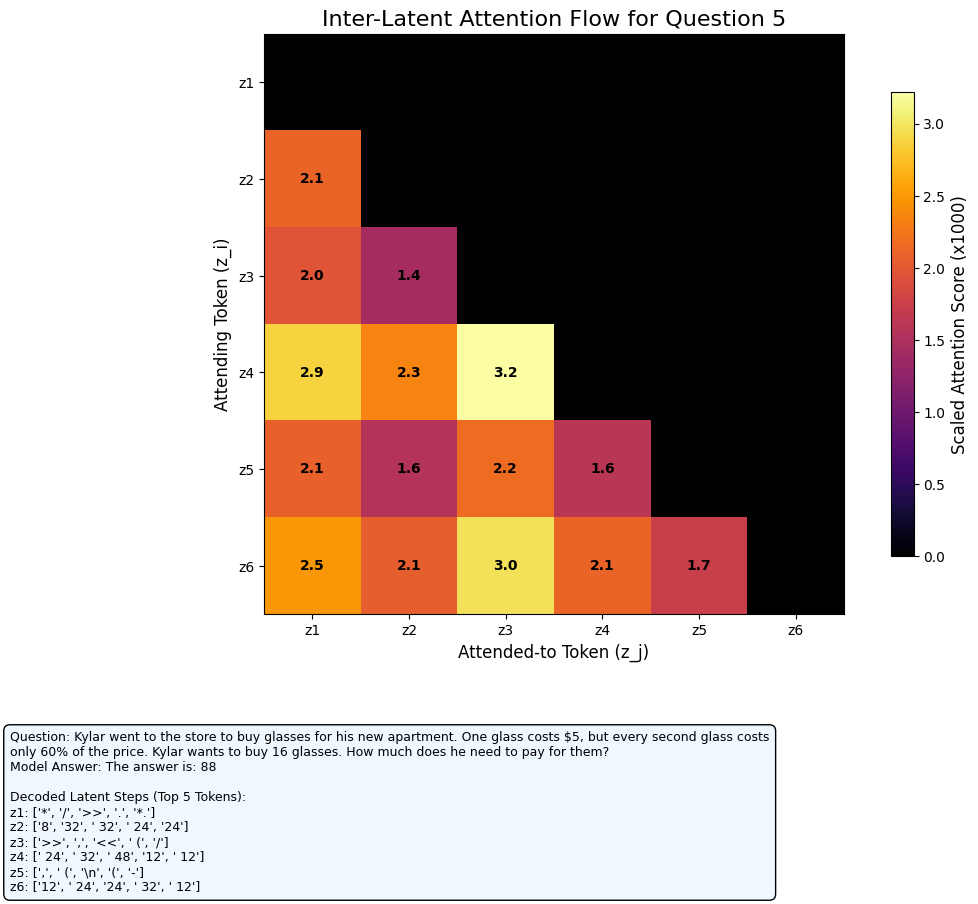

  - Processing and plotting for example 15...
✅ Saved: latentThoughtAnchorsOutput/heatmap_q15.png


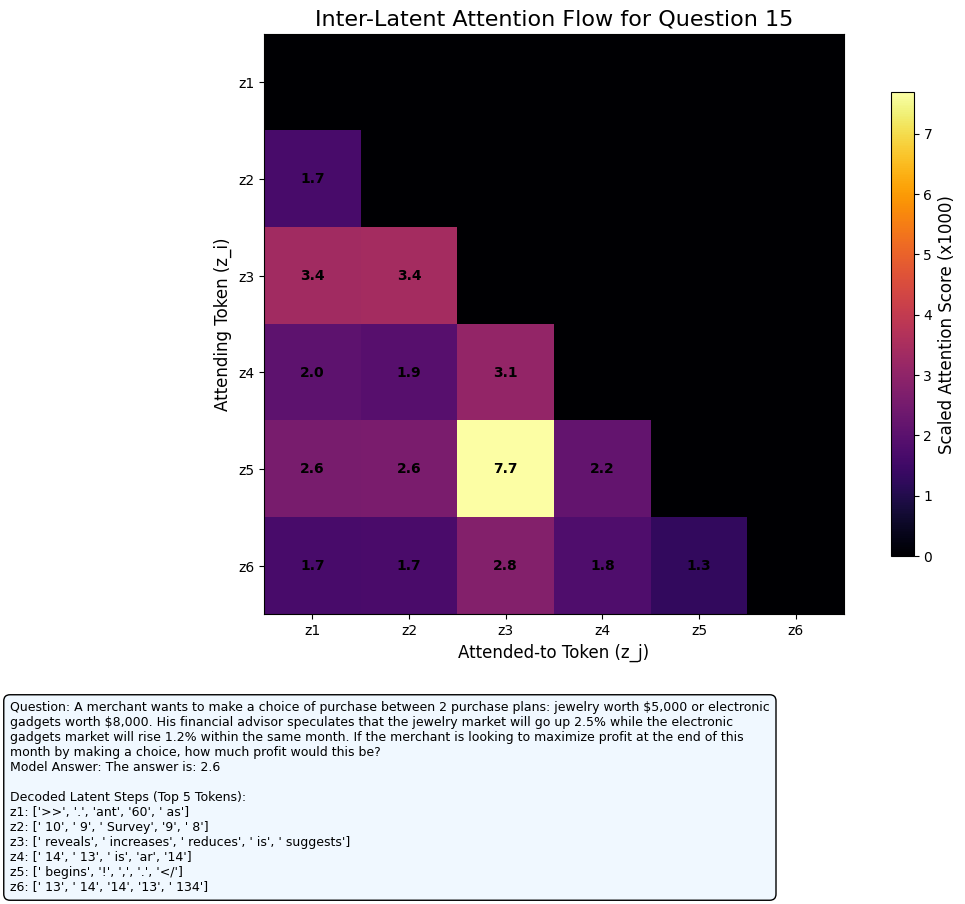

  - Processing and plotting for example 25...
✅ Saved: latentThoughtAnchorsOutput/heatmap_q25.png


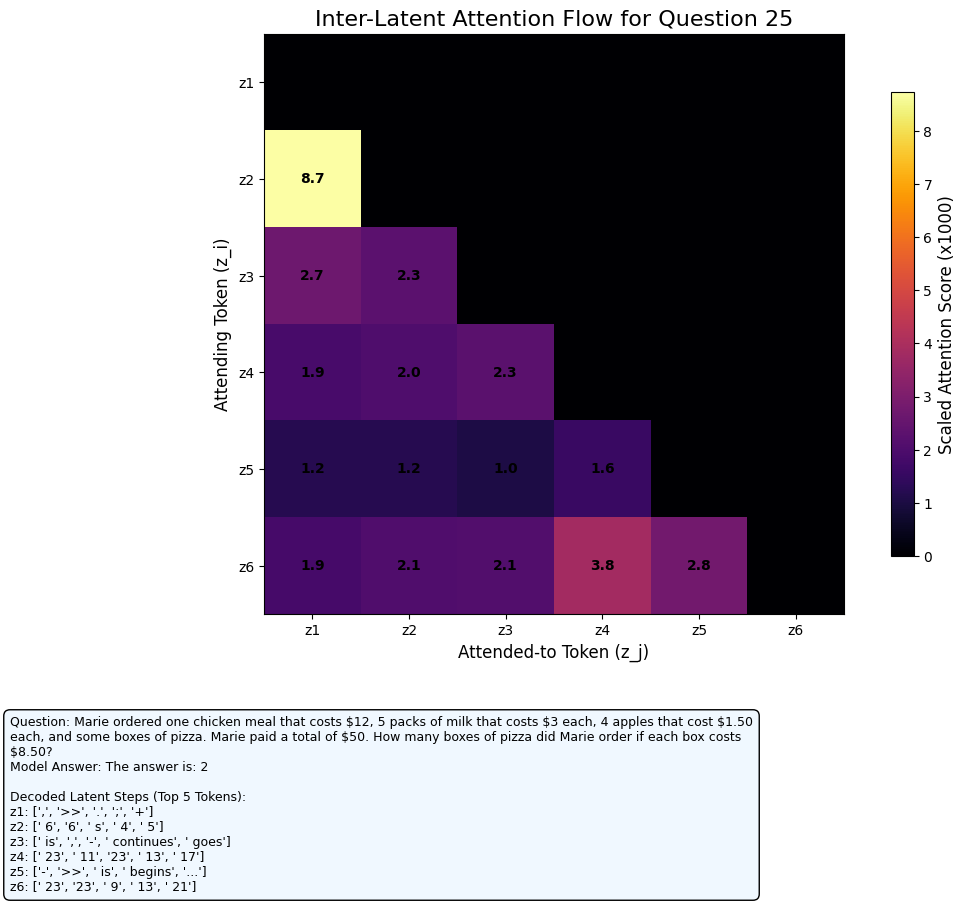

  - Processing and plotting for example 35...
✅ Saved: latentThoughtAnchorsOutput/heatmap_q35.png


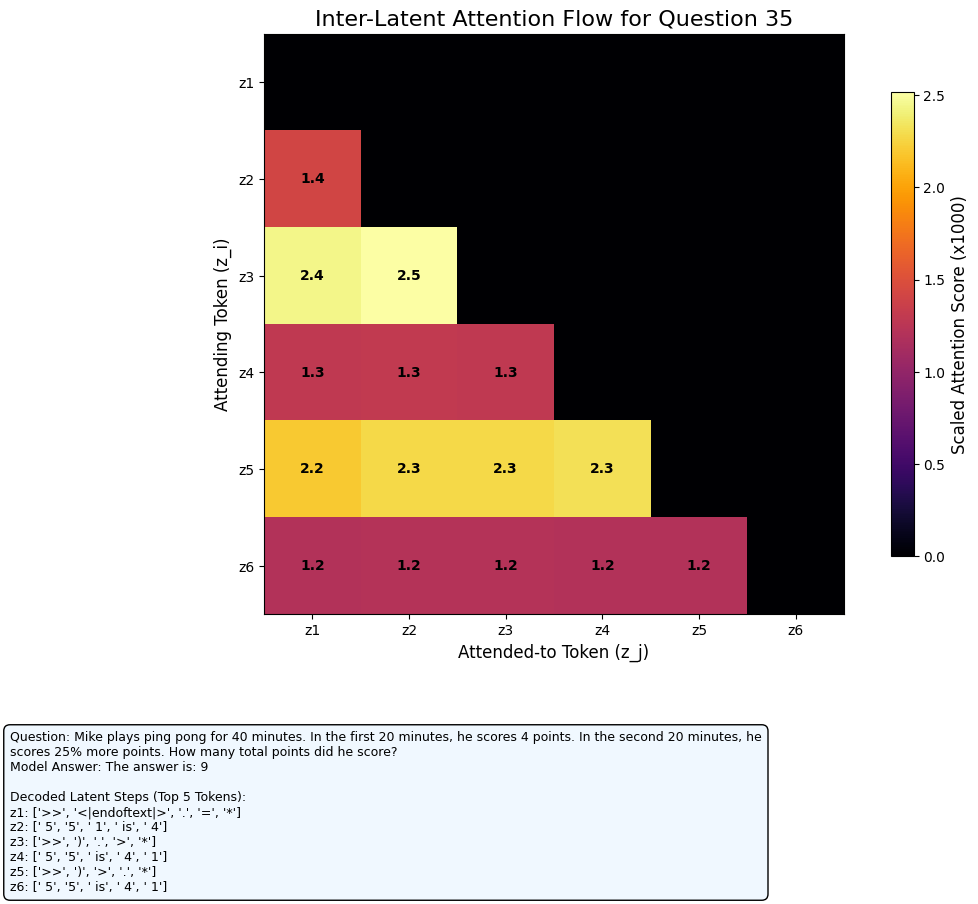

  - Processing and plotting for example 45...
✅ Saved: latentThoughtAnchorsOutput/heatmap_q45.png


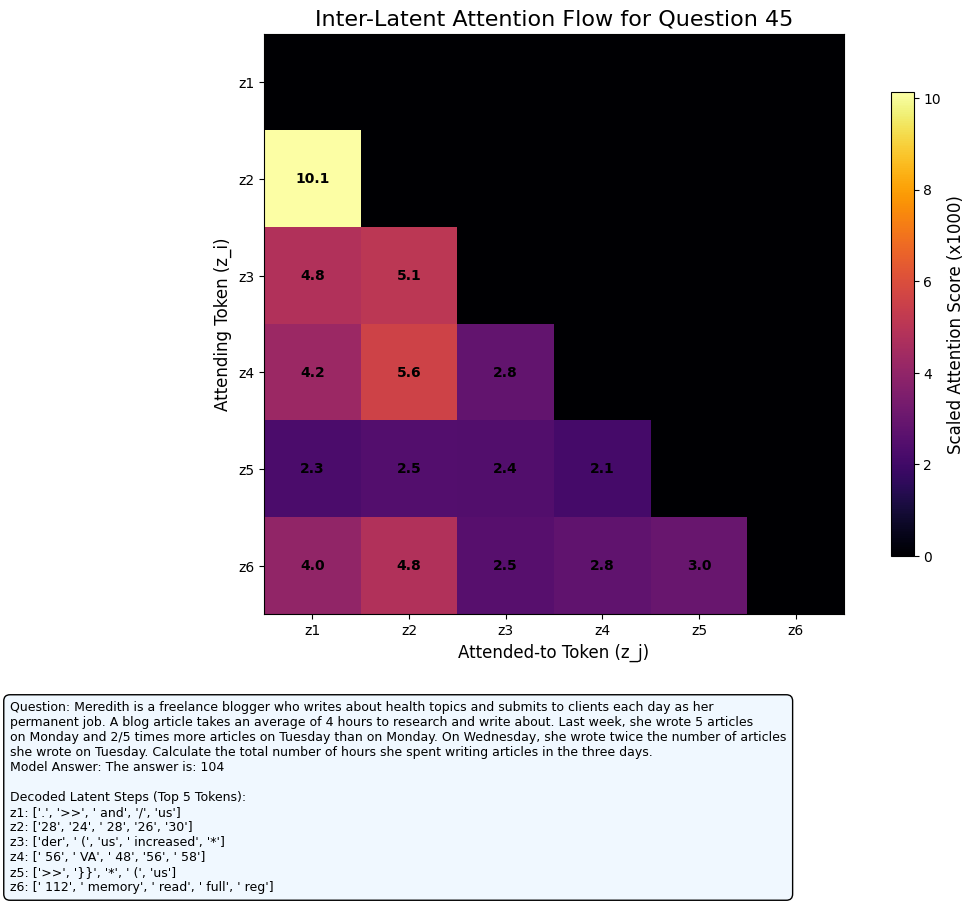


Generating heatmap for the average of all examples...
  - Calculated average prompt length: 54
✅ Saved: latentThoughtAnchorsOutput/heatmap_average_all.png


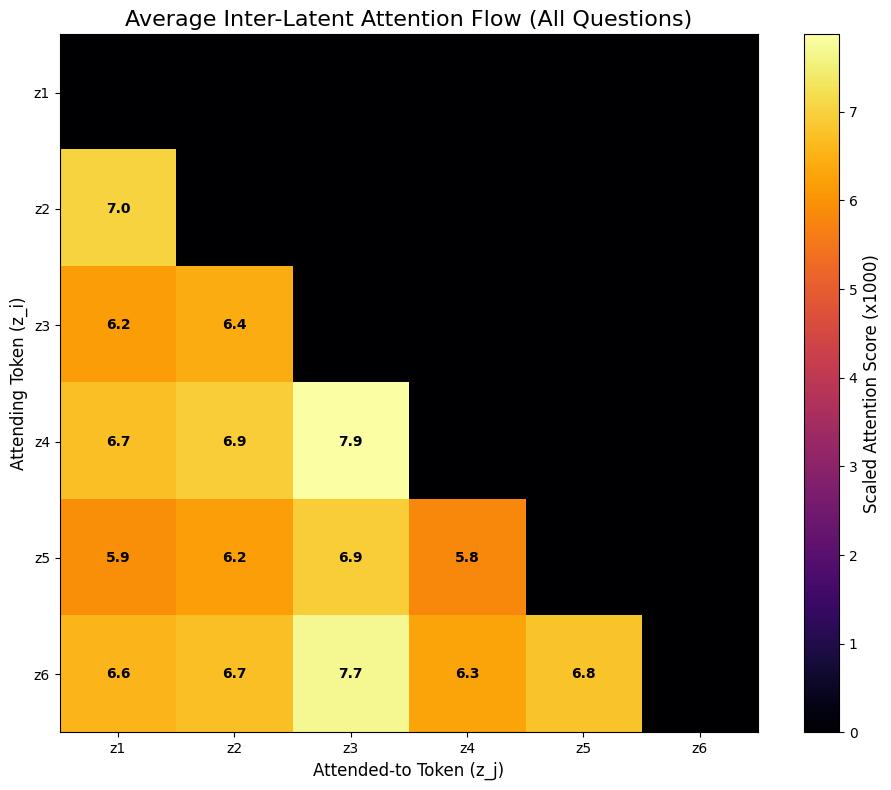


Analysis complete.


In [11]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from datasets import load_dataset
import transformers
import json
import textwrap

# --- Configuration ---
# Path to the per-question attention data you saved
ATTENTION_FILE_PATH = "per_question_attention_weights.pt"
# Path to the JSON file with detailed output
PHASE1_DATA_PATH = "phase1_data_collection.json"
# Indices of the 5 example questions you want to plot individually
EXAMPLE_INDICES_TO_PLOT = [5, 15, 25, 35, 45]
# Scaling factor for display purposes on the heatmap
SCALING_FACTOR = 1000

# --- Load Data and Tools ---
print("Loading data, tokenizer, and analysis files...")
try:
    all_attention_data = torch.load(ATTENTION_FILE_PATH)
    with open(PHASE1_DATA_PATH, 'r') as f:
        phase1_data = json.load(f)
except FileNotFoundError as e:
    print(f"Error: A required file was not found: {e.filename}")
    print("Please make sure you have run the evaluation script to generate both files.")
    exit()

tokenizer = transformers.AutoTokenizer.from_pretrained("gpt2")
dataset = load_dataset("zen-E/GSM8k-Aug")
test_set = dataset['test'].select(range(100))
print("Data loaded successfully.")

# --- Core Calculation Function for Heatmap ---
def calculate_latent_heatmap(attention_tensor, prompt_len):
    """
    Calculates the latent-to-latent attention matrix for a given attention tensor.

    Args:
        attention_tensor (torch.Tensor): Attention weights with shape
                                         [num_latent_steps, num_layers, num_heads, max_seq_len].
        prompt_len (int): The length of the initial prompt for this example.

    Returns:
        torch.Tensor: A 2D tensor of shape [num_latent_steps, num_latent_steps]
                      containing the inter-latent attention scores.
    """
    num_latent_steps = attention_tensor.shape[0]
    latent_to_latent_attention = torch.zeros(num_latent_steps, num_latent_steps)

    # i is the attending token, j is the token being attended to.
    # We only care about cases where i > j (a later latent step attending to an earlier one).
    for i in range(1, num_latent_steps):
        for j in range(i):
            # Position of the j-th latent token in the sequence
            attended_token_pos = prompt_len + j

            # Check if the position is within the bounds of the attention tensor
            if attended_token_pos < attention_tensor.shape[-1]:
                # Calculate the mean attention from z_i to z_j across all layers and heads
                score = attention_tensor[i, :, :, attended_token_pos].mean()
                latent_to_latent_attention[i, j] = score

    return latent_to_latent_attention

# --- Plot 1: Five Separate Heatmaps for Individual Examples ---
print("\nGenerating 5 separate heatmaps for individual examples with context...")
num_latent_steps = all_attention_data.shape[1]

for example_idx in EXAMPLE_INDICES_TO_PLOT:
    if example_idx < len(all_attention_data) and example_idx < len(phase1_data):
        print(f"  - Processing and plotting for example {example_idx}...")

        # --- Data Preparation ---
        attention_for_example = all_attention_data[example_idx]
        example_data = phase1_data[example_idx]

        # Calculate the precise prompt length for this specific question
        prompt_len = len(tokenizer(example_data['question_text'], return_tensors="pt")["input_ids"][0])

        # Calculate the heatmap scores
        heatmap_scores = calculate_latent_heatmap(attention_for_example, prompt_len)
        scaled_attention = heatmap_scores * SCALING_FACTOR

        # --- Plotting ---
        fig_ind, ax_ind = plt.subplots(figsize=(12, 10))
        im = ax_ind.imshow(scaled_attention.numpy(), cmap='inferno')
        ax_ind.grid(False)

        # Set titles and labels
        ax_ind.set_title(f'Inter-Latent Attention Flow for Question {example_idx}', fontsize=16)
        ax_ind.set_xlabel('Attended-to Token (z_j)', fontsize=12)
        ax_ind.set_ylabel('Attending Token (z_i)', fontsize=12)

        labels = [f'z{k+1}' for k in range(num_latent_steps)]
        ax_ind.set_xticks(np.arange(num_latent_steps))
        ax_ind.set_yticks(np.arange(num_latent_steps))
        ax_ind.set_xticklabels(labels)
        ax_ind.set_yticklabels(labels)

        cbar = fig_ind.colorbar(im, ax=ax_ind, shrink=0.8)
        cbar.set_label(f'Scaled Attention Score (x{SCALING_FACTOR})', fontsize=12)

        # Annotate heatmap with score values
        for i in range(num_latent_steps):
            for j in range(num_latent_steps):
                if i > j:
                    ax_ind.text(j, i, f'{scaled_attention[i, j]:.1f}',
                                ha="center", va="center", color="black", fontsize=10, weight='bold')

        # --- Add Context Text Below Plot ---
        plt.subplots_adjust(bottom=0.3)
        question = textwrap.fill(f"Question: {example_data['question_text']}", 120)
        model_answer = textwrap.fill(f"Model Answer: {example_data['model_prediction_text']}", 120)
        latent_info_parts = [f"z{ld['latent_token_index']+1}: {ld['decoded_intermediate_output']}" for ld in example_data['latent_data']]
        latent_info = "\n".join(latent_info_parts)
        full_context_string = f"{question}\n{model_answer}\n\nDecoded Latent Steps (Top 5 Tokens):\n{latent_info}"

        fig_ind.text(0.05, 0.02, full_context_string, ha='left', va='bottom', fontsize=9, wrap=True,
                     bbox=dict(boxstyle='round,pad=0.5', fc='aliceblue', ec='black', lw=1))

        save_path = os.path.join(OUTPUT_DIR, f"heatmap_q{example_idx}.png")
        fig_ind.savefig(save_path, dpi=300, bbox_inches="tight")
        print(f"✅ Saved: {save_path}")

        plt.show()

# --- Plot 2: Average of All 100 Examples ---
print("\nGenerating heatmap for the average of all examples...")
# Calculate average attention and average prompt length across the whole dataset
average_attention = all_attention_data.float().mean(dim=0)
avg_prompt_len = int(np.mean([len(tokenizer(ex['question'], return_tensors="pt")["input_ids"][0]) for ex in test_set]))
print(f"  - Calculated average prompt length: {avg_prompt_len}")

# Calculate heatmap scores for the averaged data
avg_heatmap_scores = calculate_latent_heatmap(average_attention, avg_prompt_len)
avg_scaled_attention = avg_heatmap_scores * SCALING_FACTOR

# --- Plotting ---
fig_avg, ax_avg = plt.subplots(figsize=(10, 8))
im_avg = ax_avg.imshow(avg_scaled_attention.numpy(), cmap='inferno')
ax_avg.grid(False)

ax_avg.set_title(f'Average Inter-Latent Attention Flow (All Questions)', fontsize=16)
ax_avg.set_xlabel('Attended-to Token (z_j)', fontsize=12)
ax_avg.set_ylabel('Attending Token (z_i)', fontsize=12)

labels = [f'z{k+1}' for k in range(num_latent_steps)]
ax_avg.set_xticks(np.arange(num_latent_steps))
ax_avg.set_yticks(np.arange(num_latent_steps))
ax_avg.set_xticklabels(labels)
ax_avg.set_yticklabels(labels)

cbar_avg = fig_avg.colorbar(im_avg)
cbar_avg.set_label(f'Scaled Attention Score (x{SCALING_FACTOR})', fontsize=12)

for i in range(num_latent_steps):
    for j in range(num_latent_steps):
        if i > j:
            ax_avg.text(j, i, f'{avg_scaled_attention[i, j]:.1f}',
                        ha="center", va="center", color="black", fontsize=10, weight='bold')

plt.tight_layout()
avg_save_path = os.path.join(OUTPUT_DIR, "heatmap_average_all.png")
fig_avg.savefig(avg_save_path, dpi=300, bbox_inches="tight")
print(f"✅ Saved: {avg_save_path}")
plt.show()

print("\nAnalysis complete.")


--- Setting up model and data for causal experiment ---
Using device: cuda


/lambda/nfs/SSSM/latent_reasoning/Scratchpad-Thinking/.venv-cu/lib/python3.11/site-packages/peft/tuners/lora/layer.py:2285: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
/tmp/ipykernel_6914/2981418748.py:240: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only

Generating prompt lengths for 1000 questions...


100%|██████████| 1000/1000 [00:00<00:00, 4481.53it/s]


Saved new prompt lengths to 'prompt_lengths.json'.

--- Testing Threshold: 0.15 ---
Found 1000 high-confidence examples.



--- Testing Threshold: 0.16 ---
Found 1000 high-confidence examples.



--- Testing Threshold: 0.17 ---
Found 185 high-confidence examples.



--- Testing Threshold: 0.18 ---
Found 68 high-confidence examples.



--- Testing Threshold: 0.19 ---
Found 57 high-confidence examples.



--- Testing Threshold: 0.20 ---
Found 56 high-confidence examples.



--- Testing Threshold: 0.21 ---
Found 49 high-confidence examples.



--- Testing Threshold: 0.22 ---
Found 48 high-confidence examples.



--- Testing Threshold: 0.23 ---
Found 48 high-confidence examples.



--- Testing Threshold: 0.24 ---
Found 48 high-confidence examples.



--- Testing Threshold: 0.25 ---
Found 47 high-confidence examples.



--- Testing Threshold: 0.26 ---
Found 42 high-confidence examples.



--- Testing Threshold: 0.27 ---
Found 36 high-confidence examples.



--- Testing Threshold: 0.28 ---
Found 36 high-confidence examples.



--- Testing Threshold: 0.29 ---
Found 36 high-confidence examples.



--- Testing Threshold: 0.30 ---
Found 35 high-confidence examples.



--- Experiment Complete: Threshold Sweep Results ---
 threshold  num_examples baseline_acc anchor_acc control_acc effect_size normalized_effect normalized_effect_smooth
      0.15          1000       42.80%     40.00%      36.00%      -4.00%             -1.26                    -1.20
      0.16          1000       42.80%     40.00%      36.40%      -3.60%             -1.14                    -0.65
      0.17           185       29.19%     21.62%      24.86%      +3.24%             +0.44                    -0.11
      0.18            68       36.76%     25.00%      29.41%      +4.41%             +0.36                    +0.58
      0.19            57       35.09%     24.56%      36.84%     +12.28%             +0.93                    +0.65
      0.20            56       35.71%     25.00%      33.93%      +8.93%             +0.67                    +0.63
      0.21            49       30.61%     24.49%      28.57%      +4.08%             +0.29                    +0.41
      0.22        

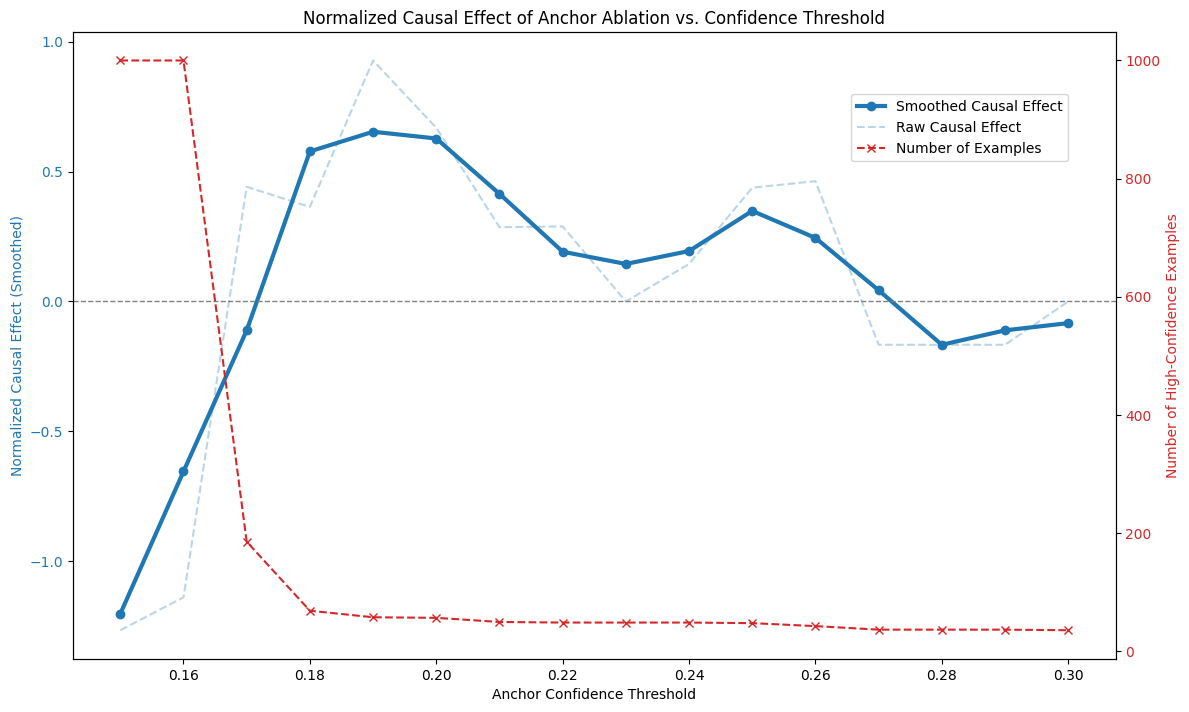

In [10]:
import torch
import numpy as np
import transformers
from datasets import load_dataset
from safetensors.torch import load_file
import os
import re
import random
from tqdm import tqdm
from peft import LoraConfig, TaskType, get_peft_model
from typing import Optional, List
from dataclasses import dataclass, field
import torch.nn as nn
import json
from collections import Counter
import pandas as pd
import matplotlib.pyplot as plt

# --- User-Provided Model Definition (from src/model.py) ---

@dataclass
class ModelArguments:
    model_name_or_path: str = field(default="mistralai/Mistral-7B-Instruct-v0.2")
    lora_r: int = field(default=128, metadata={"help": "lora rank"})
    lora_init: bool = field(default=False)
    token: Optional[str] = field(default=None)
    ckpt_dir: Optional[str] = field(default=None)
    lora_alpha: int = field(default=16)

@dataclass
class DataArguments:
    batch_size: int = field(default=1, metadata={"help": "batch size during inference"})
    data_name: str = field(default="zen-E/GSM8k-Aug")

@dataclass
class TrainingArguments(transformers.TrainingArguments):
    model_max_length: int = field(default=512)
    num_latent: int = field(default=6)
    use_lora: bool = field(default=True)
    use_prj: bool = field(default=False)
    prj_dim: int = field(default=768)
    prj_dropout: float = field(default=0.0)
    prj_no_ln: bool = field(default=False)
    inf_latent_iterations: int = field(default=6)
    remove_eos: bool = field(default=False)
    greedy: bool = field(default=True)


def get_peft_model_for_codi(model, config):
    # A simplified wrapper for get_peft_model
    return get_peft_model(model, config)

class CODI(torch.nn.Module):
    def __init__(self, model_args, training_args, lora_config):
        super().__init__()
        self.model_args = model_args
        self.training_args = training_args
        self.model_name = model_args.model_name_or_path

        self.codi = transformers.AutoModelForCausalLM.from_pretrained(
            self.model_name,
            torch_dtype=torch.bfloat16,
            use_flash_attention_2=False,
            resume_download=True,
        )

        ori_vocab_size = self.codi.config.vocab_size
        self.pad_token_id = ori_vocab_size
        self.bot_id = ori_vocab_size + 1
        self.eot_id = ori_vocab_size + 2

        self.codi.resize_token_embeddings(ori_vocab_size + 3)

        if training_args.use_lora:
            self.codi = get_peft_model_for_codi(self.codi, lora_config)

        self.dim = self.codi.config.hidden_size
        self.use_prj = training_args.use_prj
        if training_args.use_prj:
            self.prj = nn.Sequential(
                nn.Dropout(training_args.prj_dropout),
                nn.Linear(self.dim, training_args.prj_dim),
                nn.GELU(),
                nn.Linear(training_args.prj_dim, self.dim),
            )
            if not training_args.prj_no_ln:
                self.prj.add_module("ln", nn.LayerNorm(self.dim))

    def get_embd(self, model, model_name):
        base_model = model.get_base_model() if self.training_args.use_lora else model
        if "gpt2" in model_name:
            return base_model.transformer.wte
        else:
            return base_model.model.embed_tokens

# --- Configuration ---
ATTENTION_FILE_PATH = "per_question_attention_weights.pt"
PROMPT_LENGTHS_FILE_PATH = "prompt_lengths.json"
CKPT_DIR = "CODI-gpt2"
MODEL_NAME = "gpt2"

# --- Helper Functions ---

def extract_answer_number(sentence: str) -> float:
    sentence = sentence.replace(',', '')
    pred = [s for s in re.findall(r'-?\d+\.?\d*', sentence)]
    if not pred:
        return float('inf')
    return float(pred[-1])

def compute_accuracy(gold: list, pred: list):
    correct_count = sum(p == g for p, g in zip(pred, gold))
    total_count = len(gold)
    accuracy = correct_count / total_count if total_count > 0 else 0
    return accuracy, correct_count, total_count

# --- Part 1: More Robust Anchor Identification ---

def calculate_anchor_scores(attention_tensor: torch.Tensor, prompt_len: int) -> np.ndarray:
    num_latent_steps = attention_tensor.shape[0]
    anchor_scores = np.zeros(num_latent_steps)
    for j in range(num_latent_steps):
        total_attention_to_j = 0
        attended_token_pos = prompt_len + j
        if attended_token_pos >= attention_tensor.shape[-1]:
            continue
        for i in range(j + 1, num_latent_steps):
            score = attention_tensor[i, :, :, attended_token_pos].mean().item()
            total_attention_to_j += score
        anchor_scores[j] = total_attention_to_j
    return anchor_scores

def find_predicted_anchors(all_attention_data: torch.Tensor, prompt_lengths: list, threshold=0.25) -> (list[int], int):
    predicted_anchors = []
    ambiguous_count = 0
    softmax = torch.nn.Softmax(dim=0)

    for i in range(all_attention_data.shape[0]):
        attention_for_question = all_attention_data[i]
        prompt_len = prompt_lengths[i]

        scores = calculate_anchor_scores(attention_for_question, prompt_len)
        score_probs = softmax(torch.from_numpy(scores)).numpy()
        max_prob = np.max(score_probs)

        if max_prob > threshold:
            predicted_anchor_index = np.argmax(score_probs)
            predicted_anchors.append(predicted_anchor_index)
        else:
            predicted_anchors.append(-1)
            ambiguous_count += 1

    return predicted_anchors, ambiguous_count

# --- Part 2: Causal Ablation Inference Function ---

def run_inference_with_ablation(
    model, tokenizer, question_batch, training_args, device, ablation_index: Optional[int] = None
):
    model.eval()
    batch_size = question_batch["input_ids"].size(0)
    with torch.no_grad():
        outputs = model.codi(
            input_ids=question_batch["input_ids"].to(device),
            use_cache=True, output_hidden_states=True, past_key_values=None,
            attention_mask=question_batch["attention_mask"].to(device)
        )
        past_key_values = outputs.past_key_values
        latent_embd = outputs.hidden_states[-1][:, -1, :].unsqueeze(1)
        if training_args.use_prj:
            latent_embd = model.prj(latent_embd)

        for i in range(training_args.inf_latent_iterations):
            if i == ablation_index:
                latent_embd = torch.zeros_like(latent_embd)
            outputs = model.codi(
                inputs_embeds=latent_embd, use_cache=True,
                output_hidden_states=True, past_key_values=past_key_values
            )
            past_key_values = outputs.past_key_values
            latent_embd = outputs.hidden_states[-1][:, -1, :].unsqueeze(1)
            if training_args.use_prj:
                latent_embd = model.prj(latent_embd)

        if training_args.remove_eos:
            eot_emb = model.get_embd(model.codi, model.model_name)(torch.tensor([model.eot_id], dtype=torch.long, device=device)).unsqueeze(0)
        else:
            eot_emb = model.get_embd(model.codi, model.model_name)(torch.tensor([model.eot_id, tokenizer.eos_token_id], dtype=torch.long, device=device)).unsqueeze(0)

        output = eot_emb.expand(batch_size, -1, -1)
        finished = torch.zeros(batch_size, dtype=torch.bool, device=device)
        pred_tokens = [[] for _ in range(batch_size)]

        for _ in range(256):
            out = model.codi(inputs_embeds=output, use_cache=True, past_key_values=past_key_values)
            past_key_values = out.past_key_values
            logits = out.logits[:, -1, :]
            next_token_ids = torch.argmax(logits, dim=-1)
            for b in range(batch_size):
                if not finished[b]:
                    token_id = next_token_ids[b].item()
                    pred_tokens[b].append(token_id)
                    if token_id == tokenizer.eos_token_id:
                        finished[b] = True
            if finished.all():
                break
            output = model.get_embd(model.codi, model.model_name)(next_token_ids.unsqueeze(-1))

        decoded_preds = [tokenizer.decode(p, skip_special_tokens=True) for p in pred_tokens]
        return decoded_preds

# --- Main Experiment Logic ---

if __name__ == "__main__":
    print("--- Setting up model and data for causal experiment ---")
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    parser = transformers.HfArgumentParser((ModelArguments, DataArguments, TrainingArguments))
    args = [
        "--model_name_or_path", MODEL_NAME, "--bf16", "--lora_r", "128", "--lora_alpha", "32",
        "--lora_init", "--num_latent", "6", "--use_prj", "True", "--prj_dim", "768",
        "--prj_no_ln", "False", "--prj_dropout", "0.0", "--inf_latent_iterations", "6",
        "--remove_eos", "True", "--use_lora", "True", "--ckpt_dir", CKPT_DIR,
        "--output_dir", "temp", "--do_train=False", "--do_eval=False"
    ]
    model_args, data_args, training_args = parser.parse_args_into_dataclasses(args)

    lora_config = LoraConfig(
        task_type=TaskType.CAUSAL_LM,
        inference_mode=False, r=model_args.lora_r, lora_alpha=model_args.lora_alpha,
        lora_dropout=0.1, target_modules=["c_attn", "c_proj", 'c_fc'],
    )

    model = CODI(model_args, training_args, lora_config)

    try:
        state_dict = load_file(os.path.join(CKPT_DIR, "model.safetensors"), device="cpu")
    except Exception:
        state_dict = torch.load(os.path.join(CKPT_DIR, "pytorch_model.bin"), map_location="cpu")

    model.load_state_dict(state_dict, strict=False)

    if hasattr(model.codi, 'tie_weights'):
        model.codi.tie_weights()

    tokenizer = transformers.AutoTokenizer.from_pretrained(
        model_args.model_name_or_path, padding_side="left", use_fast=False
    )
    if tokenizer.pad_token_id is None:
        tokenizer.add_special_tokens({'pad_token': '[PAD]'})
        tokenizer.pad_token_id = model.pad_token_id

    model.to(device)
    model.to(torch.bfloat16)

    dataset = load_dataset(data_args.data_name)
    num_examples = 1000
    test_set = dataset['test'].select(range(num_examples))
    questions = [f"{ex['question'].strip().replace('  ', ' ')}" for ex in test_set]
    gold_answers = [float(ex['answer'].replace(",", "")) for ex in test_set]

    all_attention_data = torch.load(ATTENTION_FILE_PATH, map_location='cpu')

    prompt_lengths = []
    regenerate_lengths = True
    if os.path.exists(PROMPT_LENGTHS_FILE_PATH):
        with open(PROMPT_LENGTHS_FILE_PATH, 'r') as f:
            prompt_lengths = json.load(f)
        if len(prompt_lengths) == all_attention_data.shape[0]:
            print(f"Loading prompt lengths from '{PROMPT_LENGTHS_FILE_PATH}'...")
            regenerate_lengths = False
        else:
            print("Mismatch found. Regenerating...")

    if regenerate_lengths:
        print(f"Generating prompt lengths for {len(questions)} questions...")
        prompt_lengths = [len(tokenizer.encode(q)) for q in tqdm(questions)]
        with open(PROMPT_LENGTHS_FILE_PATH, 'w') as f:
            json.dump(prompt_lengths, f)
        print(f"Saved new prompt lengths to '{PROMPT_LENGTHS_FILE_PATH}'.")

    thresholds_to_test = np.arange(0.15, 0.31, 0.01)
    results = []

    for threshold in thresholds_to_test:
        print(f"\n--- Testing Threshold: {threshold:.2f} ---")
        predicted_anchor_indices, ambiguous_count = find_predicted_anchors(all_attention_data, prompt_lengths, threshold=threshold)
        high_confidence_indices = [i for i, idx in enumerate(predicted_anchor_indices) if idx != -1]

        if len(high_confidence_indices) < 5:
            print(f"Found only {len(high_confidence_indices)} examples. Skipping threshold to avoid noise.")
            results.append({'threshold': threshold, 'num_examples': len(high_confidence_indices), 'baseline_acc': 0, 'anchor_acc': 0, 'control_acc': 0, 'effect_size': 0, 'normalized_effect': 0})
            continue

        print(f"Found {len(high_confidence_indices)} high-confidence examples.")

        baseline_answers, anchor_ablated_answers, control_ablated_answers, filtered_gold_answers = [], [], [], []

        for i in tqdm(high_confidence_indices, desc=f"Ablation @ {threshold:.2f}", leave=False):
            question_text = questions[i]
            filtered_gold_answers.append(gold_answers[i])

            batch = tokenizer(question_text, return_tensors="pt")
            bot_id_tensor = torch.tensor([model.bot_id], dtype=torch.long).expand(batch["input_ids"].size(0), 1)
            batch["input_ids"] = torch.cat((batch["input_ids"], bot_id_tensor), dim=1)
            batch["attention_mask"] = torch.cat((batch["attention_mask"], torch.ones_like(bot_id_tensor)), dim=1)

            baseline_pred_text = run_inference_with_ablation(model, tokenizer, batch, training_args, device, ablation_index=None)[0]
            baseline_answers.append(extract_answer_number(baseline_pred_text))

            anchor_idx = predicted_anchor_indices[i]
            anchor_pred_text = run_inference_with_ablation(model, tokenizer, batch, training_args, device, ablation_index=anchor_idx)[0]
            anchor_ablated_answers.append(extract_answer_number(anchor_pred_text))

            possible_control_indices = [idx for idx in range(training_args.inf_latent_iterations) if idx != anchor_idx]
            control_idx = random.choice(possible_control_indices)
            control_pred_text = run_inference_with_ablation(model, tokenizer, batch, training_args, device, ablation_index=control_idx)[0]
            control_ablated_answers.append(extract_answer_number(control_pred_text))

        baseline_acc, _, _ = compute_accuracy(filtered_gold_answers, baseline_answers)
        anchor_acc, _, _ = compute_accuracy(filtered_gold_answers, anchor_ablated_answers)
        control_acc, _, _ = compute_accuracy(filtered_gold_answers, control_ablated_answers)

        effect_size = control_acc - anchor_acc
        normalized_effect = effect_size * np.sqrt(len(high_confidence_indices))
        results.append({'threshold': threshold, 'num_examples': len(high_confidence_indices), 'baseline_acc': baseline_acc, 'anchor_acc': anchor_acc, 'control_acc': control_acc, 'effect_size': effect_size, 'normalized_effect': normalized_effect})

    # --- Display Final Results Table and Visualization ---
    print("\n--- Experiment Complete: Threshold Sweep Results ---")
    df = pd.DataFrame(results)

    # Calculate moving average to smooth the noisy effect size
    df['normalized_effect_smooth'] = df['normalized_effect'].rolling(window=3, center=True, min_periods=1).mean()

    display_df = df.copy()
    display_df['baseline_acc'] = display_df['baseline_acc'].apply(lambda x: f"{x:.2%}")
    display_df['anchor_acc'] = display_df['anchor_acc'].apply(lambda x: f"{x:.2%}")
    display_df['control_acc'] = display_df['control_acc'].apply(lambda x: f"{x:.2%}")
    display_df['effect_size'] = display_df['effect_size'].apply(lambda x: f"{x:+.2%}")
    display_df['normalized_effect'] = display_df['normalized_effect'].apply(lambda x: f"{x:+.2f}")
    display_df['normalized_effect_smooth'] = display_df['normalized_effect_smooth'].apply(lambda x: f"{x:+.2f}")


    print(display_df.to_string(index=False))
    print("\n'normalized_effect' is (effect_size * sqrt(num_examples)). It rewards stable effects in larger samples.")
    print("----------------------------------------------------")

    # --- Updated Visualization with Moving Average ---
    fig, ax1 = plt.subplots(figsize=(12, 7))

    # Plot Smoothed Moving Average on the primary y-axis
    color = 'tab:blue'
    ax1.set_xlabel('Anchor Confidence Threshold')
    ax1.set_ylabel('Normalized Causal Effect (Smoothed)', color=color)
    ax1.plot(df['threshold'], df['normalized_effect_smooth'], color=color, marker='o', linewidth=3, label='Smoothed Causal Effect')
    # Plot raw data faintly in the background
    ax1.plot(df['threshold'], df['normalized_effect'], color=color, alpha=0.3, linestyle='--', label='Raw Causal Effect')
    ax1.tick_params(axis='y', labelcolor=color)
    ax1.axhline(0, color='gray', linestyle='--', linewidth=1)

    # Create a secondary y-axis for the number of examples
    ax2 = ax1.twinx()
    color = 'tab:red'
    ax2.set_ylabel('Number of High-Confidence Examples', color=color)
    ax2.plot(df['threshold'], df['num_examples'], color=color, marker='x', linestyle='--', label='Number of Examples')
    ax2.tick_params(axis='y', labelcolor=color)

    fig.tight_layout()
    plt.title('Normalized Causal Effect of Anchor Ablation vs. Confidence Threshold')
    fig.legend(loc="upper right", bbox_to_anchor=(0.9, 0.9))
    plt.show()
